<a href="https://colab.research.google.com/github/sikinka/untitled/blob/master/Translator7VINS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Část 1
- Úvod
- Model overview
- Preloaded model & tokenizer
- Quick test

## Část 2
- Update model
- Load dataset
- Data formatting loader

## Část 3
- Training
- Testing
- Recreate demo

# Stažení modulů

In [2]:
!pip install transformers sentencepiece datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 37.1 MB/s 
     |████████████████████████████████| 1.3 MB 55.6 MB/s 
     |████████████████████████████████| 451 kB 75.4 MB/s 
     |████████████████████████████████| 182 kB 80.7 MB/s 
     |████████████████████████████████| 7.6 MB 63.2 MB/s 
     |████████████████████████████████| 212 kB 70.6 MB/s 
     |████████████████████████████████| 132 kB 75.8 MB/s 
     |████████████████████████████████| 127 kB 84.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [3]:
from datasets import load_dataset
from google.colab import drive
from IPython.display import display
from IPython.html import widgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import optim
from torch.nn import functional as F
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm_notebook

sns.set()

/usr/local/lib/python3.8/dist-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


In [4]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# Inicializace cesty
model_repo = 'google/mt5-small'
model_path = '/content/gdrive/My Drive/mt5_translation.pt'
max_seq_len = 8

# Načtení tokenizeru a modelu

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_repo)

Downloading:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/553 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/transformers/convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [7]:
# Odkaz na model: https://huggingface.co/google/mt5-small
model = AutoModelForSeq2SeqLM.from_pretrained(model_repo)
model = model.cuda()

Downloading:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

# test funkčnosti tokenizeru

In [8]:
token_ids = tokenizer.encode(
    '<es> This will be translated to espa! (hopefully)',
    return_tensors='pt').cuda()
print(token_ids)

model_out = model.generate(token_ids)
print(model_out)

output_text = tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(model_out[0]))
print(output_text)

tensor([[  1042,    299,    669,   1494,    898,    390,  37194,    285,    288,
          15659,    309,    274, 116024,  11994,    271,      1]],
       device='cuda:0')
tensor([[     0, 250099,      1]], device='cuda:0')
<pad> <extra_id_0></s>


/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1387: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


# Steps
1. Load the pretrained model and tokenizer
2. Load dataset
3. Transform dataset into input (entails a minor model change)
4. Train/finetune the model on our dataset
5. Test the model

# Test Tokenizeru 2

In [9]:
example_input_str = '<es> This is just a test.'
input_ids = tokenizer.encode(example_input_str, return_tensors='pt')
print('Input IDs:', input_ids)

tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
print('Tokens:', tokens)

Input IDs: tensor([[1042,  299,  669, 1494,  339, 1627,  259,  262, 2978,  260,    1]])
Tokens: ['▁<', 'es', '>', '▁This', '▁is', '▁just', '▁', 'a', '▁test', '.', '</s>']


In [10]:
sorted(tokenizer.vocab.items(), key=lambda x: x[1])

[('<pad>', 0),
 ('</s>', 1),
 ('<unk>', 2),
 ('<0x00>', 3),
 ('<0x01>', 4),
 ('<0x02>', 5),
 ('<0x03>', 6),
 ('<0x04>', 7),
 ('<0x05>', 8),
 ('<0x06>', 9),
 ('<0x07>', 10),
 ('<0x08>', 11),
 ('<0x09>', 12),
 ('<0x0A>', 13),
 ('<0x0B>', 14),
 ('<0x0C>', 15),
 ('<0x0D>', 16),
 ('<0x0E>', 17),
 ('<0x0F>', 18),
 ('<0x10>', 19),
 ('<0x11>', 20),
 ('<0x12>', 21),
 ('<0x13>', 22),
 ('<0x14>', 23),
 ('<0x15>', 24),
 ('<0x16>', 25),
 ('<0x17>', 26),
 ('<0x18>', 27),
 ('<0x19>', 28),
 ('<0x1A>', 29),
 ('<0x1B>', 30),
 ('<0x1C>', 31),
 ('<0x1D>', 32),
 ('<0x1E>', 33),
 ('<0x1F>', 34),
 ('<0x20>', 35),
 ('<0x21>', 36),
 ('<0x22>', 37),
 ('<0x23>', 38),
 ('<0x24>', 39),
 ('<0x25>', 40),
 ('<0x26>', 41),
 ('<0x27>', 42),
 ('<0x28>', 43),
 ('<0x29>', 44),
 ('<0x2A>', 45),
 ('<0x2B>', 46),
 ('<0x2C>', 47),
 ('<0x2D>', 48),
 ('<0x2E>', 49),
 ('<0x2F>', 50),
 ('<0x30>', 51),
 ('<0x31>', 52),
 ('<0x32>', 53),
 ('<0x33>', 54),
 ('<0x34>', 55),
 ('<0x35>', 56),
 ('<0x36>', 57),
 ('<0x37>', 58),
 ('<0x38>',

# Přípraa Datasetu

In [11]:
# Source: https://huggingface.co/datasets/opus100
dataset = load_dataset("opus100", "en-es")

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset opus100 downloaded and prepared to /root/.cache/huggingface/datasets/opus100/en-es/0.0.0/256f3196b69901fb0c79810ef468e2c4ed84fbd563719920b1ff1fdc750f7704. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [12]:
train_dataset = dataset['train']
test_dataset = dataset['test']

In [13]:
train_dataset[1]

{'translation': {'en': "I'm out of here.", 'es': 'Me voy de aquí.'}}

In [14]:
LANG_TOKEN_MAPPING = {
    'en': '<en>',
    'es': '<es>'
}

In [15]:
special_tokens_dict = {'additional_special_tokens': list(LANG_TOKEN_MAPPING.values())}
tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

Embedding(250102, 512)

In [16]:
token_ids = tokenizer.encode(
    example_input_str, return_tensors='pt', padding='max_length',
    truncation=True, max_length=max_seq_len)
print(token_ids)

tokens = tokenizer.convert_ids_to_tokens(token_ids[0])
print(tokens)

tensor([[250101,   1494,    339,   1627,    259,    262,   2978,      1]])
['<es>', '▁This', '▁is', '▁just', '▁', 'a', '▁test', '</s>']


In [17]:
def encode_input_str(text, target_lang, tokenizer, seq_len,
                     lang_token_map=LANG_TOKEN_MAPPING):
  target_lang_token = lang_token_map[target_lang]

  # Tokenize and add special tokens
  input_ids = tokenizer.encode(
      text = target_lang_token + text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return input_ids[0]
  
def encode_target_str(text, tokenizer, seq_len,
                      lang_token_map=LANG_TOKEN_MAPPING):
  token_ids = tokenizer.encode(
      text = text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)
  
  return token_ids[0]

def format_translation_data(translations, lang_token_map,
                            tokenizer, seq_len=128):
  # Choose a random 2 languages for in i/o
  langs = list(lang_token_map.keys())
  input_lang, target_lang = np.random.choice(langs, size=2, replace=False)

  # Get the translations for the batch
  input_text = translations[input_lang]
  target_text = translations[target_lang]

  if input_text is None or target_text is None:
    return None

  input_token_ids = encode_input_str(
      input_text, target_lang, tokenizer, seq_len, lang_token_map)
  
  target_token_ids = encode_target_str(
      target_text, tokenizer, seq_len, lang_token_map)

  return input_token_ids, target_token_ids

def transform_batch(batch, lang_token_map, tokenizer):
  inputs = []
  targets = []
  for translation_set in batch['translation']:
    formatted_data = format_translation_data(
        translation_set, lang_token_map, tokenizer, max_seq_len)
    
    if formatted_data is None:
      continue
    
    input_ids, target_ids = formatted_data
    inputs.append(input_ids.unsqueeze(0))
    targets.append(target_ids.unsqueeze(0))
    
  batch_input_ids = torch.cat(inputs).cuda()
  batch_target_ids = torch.cat(targets).cuda()

  return batch_input_ids, batch_target_ids

def get_data_generator(dataset, lang_token_map, tokenizer, batch_size=32):
  dataset = dataset.shuffle()
  for i in range(0, len(dataset), batch_size):
    raw_batch = dataset[i:i+batch_size]
    yield transform_batch(raw_batch, lang_token_map, tokenizer)

In [18]:
# Testing `data_transform`
in_ids, out_ids = format_translation_data(
    train_dataset[0]['translation'], LANG_TOKEN_MAPPING, tokenizer)

print(' '.join(tokenizer.convert_ids_to_tokens(in_ids)))
print(' '.join(tokenizer.convert_ids_to_tokens(out_ids)))

# Generátor testovacích dat
data_gen = get_data_generator(train_dataset, LANG_TOKEN_MAPPING, tokenizer, 8)
data_batch = next(data_gen)
print('Input shape:', data_batch[0].shape)
print('Output shape:', data_batch[1].shape)

<en> ▁Fu eron ▁los ▁ asbest os ▁ aquí . ▁¡ Es o ▁es ▁lo ▁que ▁ ocurr ió ! </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
▁It ▁was ▁the ▁ asbest os ▁in ▁here , ▁that ' s ▁what ▁did ▁it ! </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

# Ladění, trénování

In [19]:
# Konstanty
n_epochs = 8
batch_size = 16
print_freq = 50
checkpoint_freq = 1000
lr = 5e-4
n_batches = int(np.ceil(len(train_dataset) / batch_size))
total_steps = n_epochs * n_batches
n_warmup_steps = int(total_steps * 0.01)

In [20]:
# Optimizátor
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, n_warmup_steps, total_steps)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [21]:
losses = []

In [22]:
def eval_model(model, gdataset, max_iters=8):
  test_generator = get_data_generator(gdataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)
  eval_losses = []
  for i, (input_batch, label_batch) in enumerate(test_generator):
    if i >= max_iters:
      break

    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)
    eval_losses.append(model_out.loss.item())

  return np.mean(eval_losses)

In [23]:
for epoch_idx in range(n_epochs):
  # Randomizace pořadí dat
  data_generator = get_data_generator(train_dataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)
                
  for batch_idx, (input_batch, label_batch) \
      in tqdm_notebook(enumerate(data_generator), total=n_batches):
    optimizer.zero_grad()

    # předání
    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)

    # výpočet ztrát a vah
    loss = model_out.loss
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()

    # tisk průběžných výsledků trénování
    if (batch_idx + 1) % print_freq == 0:
      avg_loss = np.mean(losses[-print_freq:])
      print('Epoch: {} | Step: {} | Avg. loss: {:.3f} | lr: {}'.format(
          epoch_idx+1, batch_idx+1, avg_loss, scheduler.get_last_lr()[0]))
      
    if (batch_idx + 1) % checkpoint_freq == 0:
      test_loss = eval_model(model, test_dataset)
      print('Saving model with test loss of {:.3f}'.format(test_loss))
      torch.save(model.state_dict(), model_path)

torch.save(model.state_dict(), model_path)

<ipython-input-23-35dc4c1cb234>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  in tqdm_notebook(enumerate(data_generator), total=n_batches):


  0%|          | 0/62500 [00:00<?, ?it/s]

Epoch: 1 | Step: 50 | Avg. loss: 30.453 | lr: 5e-06
Epoch: 1 | Step: 100 | Avg. loss: 26.857 | lr: 1e-05
Epoch: 1 | Step: 150 | Avg. loss: 22.048 | lr: 1.5e-05
Epoch: 1 | Step: 200 | Avg. loss: 19.419 | lr: 2e-05
Epoch: 1 | Step: 250 | Avg. loss: 16.394 | lr: 2.5e-05
Epoch: 1 | Step: 300 | Avg. loss: 14.854 | lr: 3e-05
Epoch: 1 | Step: 350 | Avg. loss: 13.569 | lr: 3.5000000000000004e-05
Epoch: 1 | Step: 400 | Avg. loss: 11.657 | lr: 4e-05
Epoch: 1 | Step: 450 | Avg. loss: 11.567 | lr: 4.4999999999999996e-05
Epoch: 1 | Step: 500 | Avg. loss: 10.816 | lr: 5e-05
Epoch: 1 | Step: 550 | Avg. loss: 10.021 | lr: 5.5e-05
Epoch: 1 | Step: 600 | Avg. loss: 9.224 | lr: 6e-05
Epoch: 1 | Step: 650 | Avg. loss: 8.624 | lr: 6.500000000000001e-05
Epoch: 1 | Step: 700 | Avg. loss: 8.271 | lr: 7.000000000000001e-05
Epoch: 1 | Step: 750 | Avg. loss: 7.733 | lr: 7.5e-05
Epoch: 1 | Step: 800 | Avg. loss: 7.320 | lr: 8e-05
Epoch: 1 | Step: 850 | Avg. loss: 6.840 | lr: 8.5e-05
Epoch: 1 | Step: 900 | Avg. lo

KeyboardInterrupt: ignored

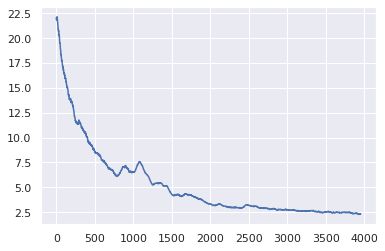

In [24]:
# Graf který znázorňuje ztráty

window_size = 50
smoothed_losses = []
for i in range(len(losses)-window_size):
  smoothed_losses.append(np.mean(losses[i:i+window_size]))

plt.plot(smoothed_losses[100:])

# Testování funkčnosti

In [25]:
test_sentence = test_dataset[0]['translation']['en']
print('Raw input text:', test_sentence)

input_ids = encode_input_str(
    text = test_sentence,
    target_lang = 'es',
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0).cuda()

print('Truncated input text:', tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[0])))

Raw input text: If your country produced ODS for this purpose, please enter the amount so produced in column 6 on Data Form 3.”
Truncated input text: <es> If your country produced ODS for this purpose, please enter the amount so produce</s>


In [27]:
output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=3)
# print(output_tokens)
for token_set in output_tokens:
  print(tokenizer.decode(token_set, skip_special_tokens=True))

Cuando un país producía 
Cuando la asamblea
Cuando usted produce ODS


In [34]:
#@title VINS AI překládač
input_text = 'yo tengo un perro grande' #@param {type:"string"}
output_language = 'en' #@param ["es", "en"]

input_ids = encode_input_str(
    text = input_text,
    target_lang = output_language,
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0).cuda()

output_tokens = model.generate(input_ids, num_beams=20, length_penalty=0.2)
print(input_text + '  ->  ' + \
      tokenizer.decode(output_tokens[0], skip_special_tokens=True))

yo tengo un perro grande  ->  I've got a 
